# 

In [1]:
import warnings

import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from matplotlib.figure import figaspect
from tqdm.notebook import tqdm

plt.style.use("bmh")
plt.rc("figure", figsize=figaspect(3 / 4))

- define an objective function
- determine the lower and upper bound of the objective function
- plot the ground truth

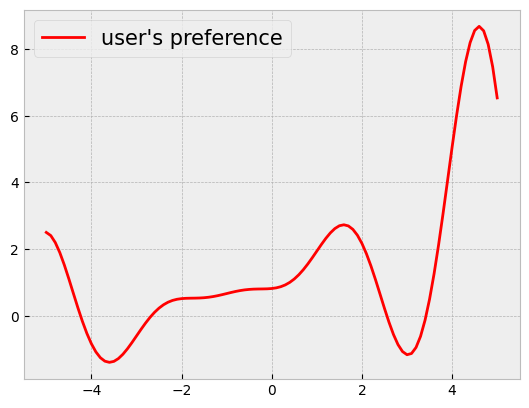

In [2]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
ys = objective(xs)

plt.plot(xs, ys, label="user's preference", c="r")
plt.legend(fontsize=15)

plt.show()

In [3]:
def compare(y):
    assert y.numel() == 2

    if y.flatten()[0] > y.flatten()[1]:
        return torch.tensor([[0, 1]]).long()
    else:
        return torch.tensor([[1, 0]]).long()

In [4]:
torch.manual_seed(0)

train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(2, 1)
train_x

tensor([[-0.0374],
        [ 2.6822]])

In [5]:
train_y = objective(train_x)
train_comp = compare(train_y)

train_y, train_comp

(tensor([[ 0.8137],
         [-0.4992]]),
 tensor([[0, 1]]))

In [6]:
train_x = torch.tensor([[0.0], [3.0], [-4.0], [4.0]], dtype=torch.double)
train_comp = torch.tensor(
    [
        [0, 1],  # f(0) > f(3)
        [0, 2],  # f(0) > f(-4)
        [3, 0],  # f(4) > f(0)
    ],
    dtype=torch.double,
)

In [7]:
model = PairwiseGP(train_x, train_comp)
model.covar_module.raw_outputscale.requires_grad_(False)
mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

In [8]:
with torch.no_grad():
    pred_dist = model(xs.unsqueeze(-1))
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()

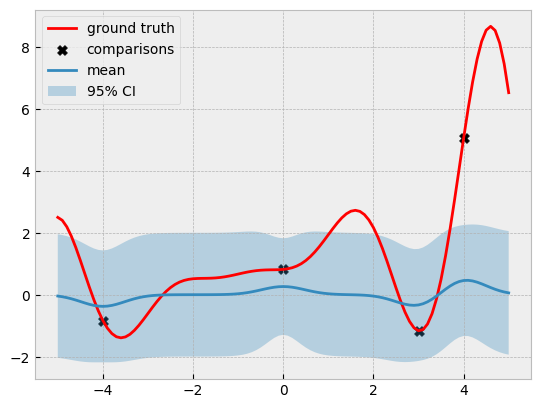

In [9]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, objective(train_x), c="k", marker="X", s=50, label="comparisons")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

plt.legend();